In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import os
import util
import easyocr

In [ ]:
!pip install easyocr

## Licence plate extraction with OpenCV

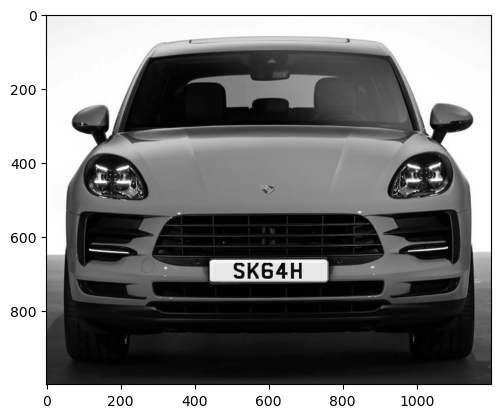

In [2]:
img_bgr = cv2.imread('plate_img/SK64H.webp')
img_plate = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(img_plate, cv2.COLOR_BGR2RGB))

### Filterind and edge detection for localization 

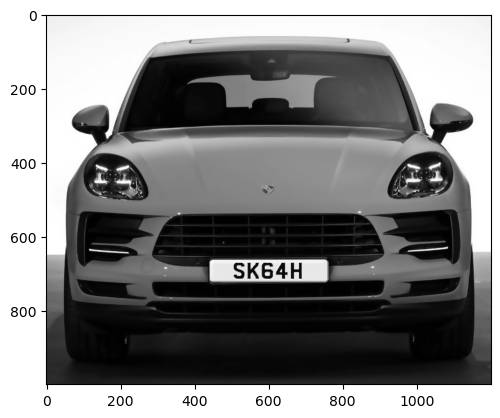

In [3]:
bfilter = cv2.bilateralFilter(img_plate, 11, 17, 17) #Noise reduction
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB))

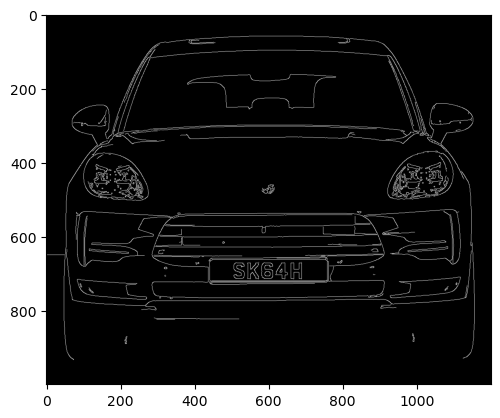

In [4]:
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

### Contours detection

In [5]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [6]:
contours

[array([[[753, 661]],
 
        [[752, 662]],
 
        [[448, 662]],
 
        [[446, 664]],
 
        [[444, 664]],
 
        [[441, 667]],
 
        [[441, 670]],
 
        [[440, 671]],
 
        [[440, 676]],
 
        [[441, 677]],
 
        [[440, 678]],
 
        [[441, 679]],
 
        [[441, 717]],
 
        [[442, 718]],
 
        [[442, 719]],
 
        [[443, 719]],
 
        [[444, 720]],
 
        [[444, 721]],
 
        [[445, 722]],
 
        [[446, 722]],
 
        [[447, 723]],
 
        [[756, 723]],
 
        [[761, 718]],
 
        [[761, 667]],
 
        [[760, 667]],
 
        [[757, 664]],
 
        [[756, 664]]], dtype=int32),
 array([[[448, 663]],
 
        [[449, 662]],
 
        [[753, 662]],
 
        [[754, 663]],
 
        [[755, 663]],
 
        [[759, 667]],
 
        [[758, 668]],
 
        [[758, 716]],
 
        [[755, 719]],
 
        [[446, 719]],
 
        [[756, 719]],
 
        [[757, 718]],
 
        [[757, 717]],
 
        [[758, 716]],
 
   

In [7]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [8]:
location

array([[[761, 667]],

       [[448, 662]],

       [[441, 717]],

       [[756, 723]]], dtype=int32)

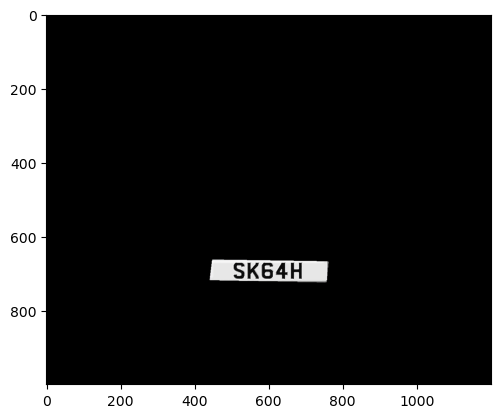

In [9]:
mask = np.zeros(img_plate.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

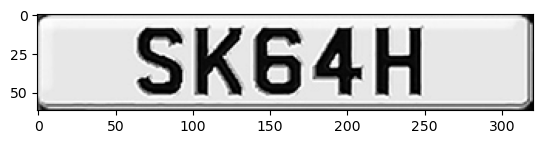

In [10]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_plate = img_plate[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))

## Licence plate extraction with YOLOv3 (trained model is cloned from github)

In [11]:
model_path = os.path.join('YOLOv3_plates', 'config', 'darknet-yolov3.cfg')
weights_path = os.path.join('YOLOv3_plates', 'weights', 'model.weights')
classes_path = os.path.join('YOLOv3_plates', 'classes.names')

In [12]:
# load model
model = cv2.dnn.readNetFromDarknet(model_path, weights_path)

In [13]:
img_col_plate = cv2.imread('plate_img/SK64H.webp', cv2.IMREAD_COLOR)
img_proc = cv2.dnn.blobFromImage(img_col_plate, 1 / 255, (320, 320), (0, 0, 0), True)

In [14]:
H,W, _ = img_col_plate.shape

In [15]:
model.setInput(img_proc)
detections = util.get_outputs(model)
bboxes = []
class_ids = []
scores = []

In [16]:
detections

[array([0.49184436, 0.69295037, 0.23100242, 0.06737642, 0.4109451 ,
        0.41043743], dtype=float32)]

In [17]:
for detection in detections:
    bbox = detection[:4]

    xc, yc, w, h = bbox
    bbox = [int(xc * W), int(yc * H), int(w * W), int(h * H)]

    bbox_confidence = detection[4]

    class_id = np.argmax(detection[5:])
    score = np.amax(detection[5:])

    bboxes.append(bbox)
    class_ids.append(class_id)
    scores.append(score)

In [18]:
bboxes, class_ids, scores = util.NMS(bboxes, class_ids, scores)

In [19]:
bboxes

array([[590, 691, 277,  67]])

In [21]:
scores

array([0.41043743], dtype=float32)

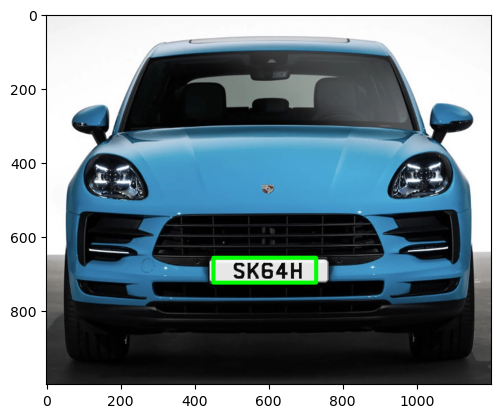

In [22]:
for bbox_, bbox in enumerate(bboxes):
    xc, yc, w, h = bbox
    img = cv2.rectangle(img_col_plate,
                        (int(xc - (w / 2)), int(yc - (h / 2))),
                        (int(xc + (w / 2)), int(yc + (h / 2))),
                        (0, 255, 0),
                        10)

plt.imshow(cv2.cvtColor(img_col_plate, cv2.COLOR_BGR2RGB))
plt.show()

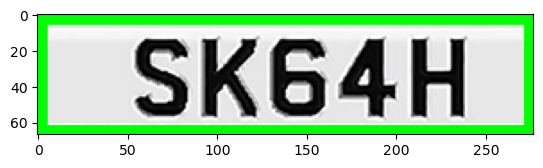

In [23]:
license_plate = img_col_plate[int(yc - (h / 2)):int(yc + (h / 2)), int(xc - (w / 2)):int(xc + (w / 2)), :]
plt.imshow(cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB))
plt.show()

### Read License Plate

In [24]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_plate)
result

[([[58, 2], [258, 2], [258, 58], [58, 58]], 'Sk64H', 0.5214298429757559)]

### Rendering

In [25]:
result

[([[58, 2], [258, 2], [258, 58], [58, 58]], 'Sk64H', 0.5214298429757559)]

In [26]:
result[0]

([[58, 2], [258, 2], [258, 58], [58, 58]], 'Sk64H', 0.5214298429757559)

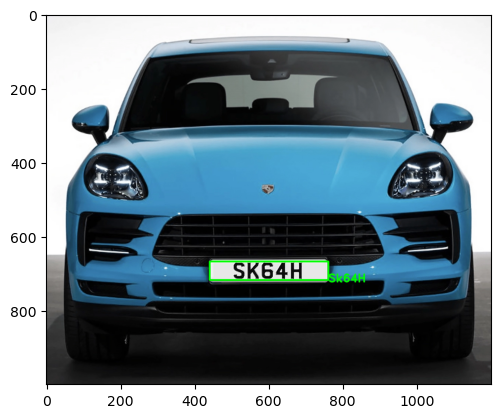

In [27]:
license = result[0][-2]
font = cv2.FONT_HERSHEY_DUPLEX
res = cv2.putText(img_bgr, text=license, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img_bgr, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))